<a href="https://colab.research.google.com/github/soheldatta17/Knee-Arthritis-Detection/blob/main/KneeArthritisDetectionMainSample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knee Arthritis Detection using CNN.



## 1. Dataset preparation.

#### 1.1. Download dataset from kaggle.

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
  0% 0.00/58.3M [00:00<?, ?B/s]
100% 58.3M/58.3M [00:00<00:00, 1.40GB/s]


In [ ]:
!unzip -qq annotated-dataset-for-knee-arthritis-detection.zip

Commands above will create a folder with the following content:

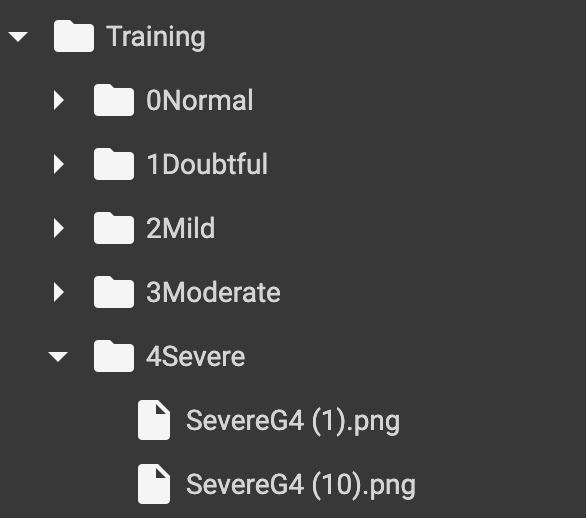

**Import all the necessary modules**

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import split_dataset
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ============ Squeeze-and-Excitation (SE) Block for Channel Attention ============
def se_block(input_tensor, ratio=16):
    """Channel attention mechanism: learns to weight feature channels.
    Args:
        input_tensor: input feature map
        ratio: compression ratio for internal dimension (default 16)
    """
    filters = K.int_shape(input_tensor)[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)  # Squeeze spatial dims
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation="relu")(se)  # Compress
    se = layers.Dense(filters, activation="sigmoid")(se)  # Excitation
    return layers.Multiply()([input_tensor, se])  # Scale input channels
# =====================================================================

#### 1.2. Load dataset from the file system.

Found 1650 files belonging to 5 classes.


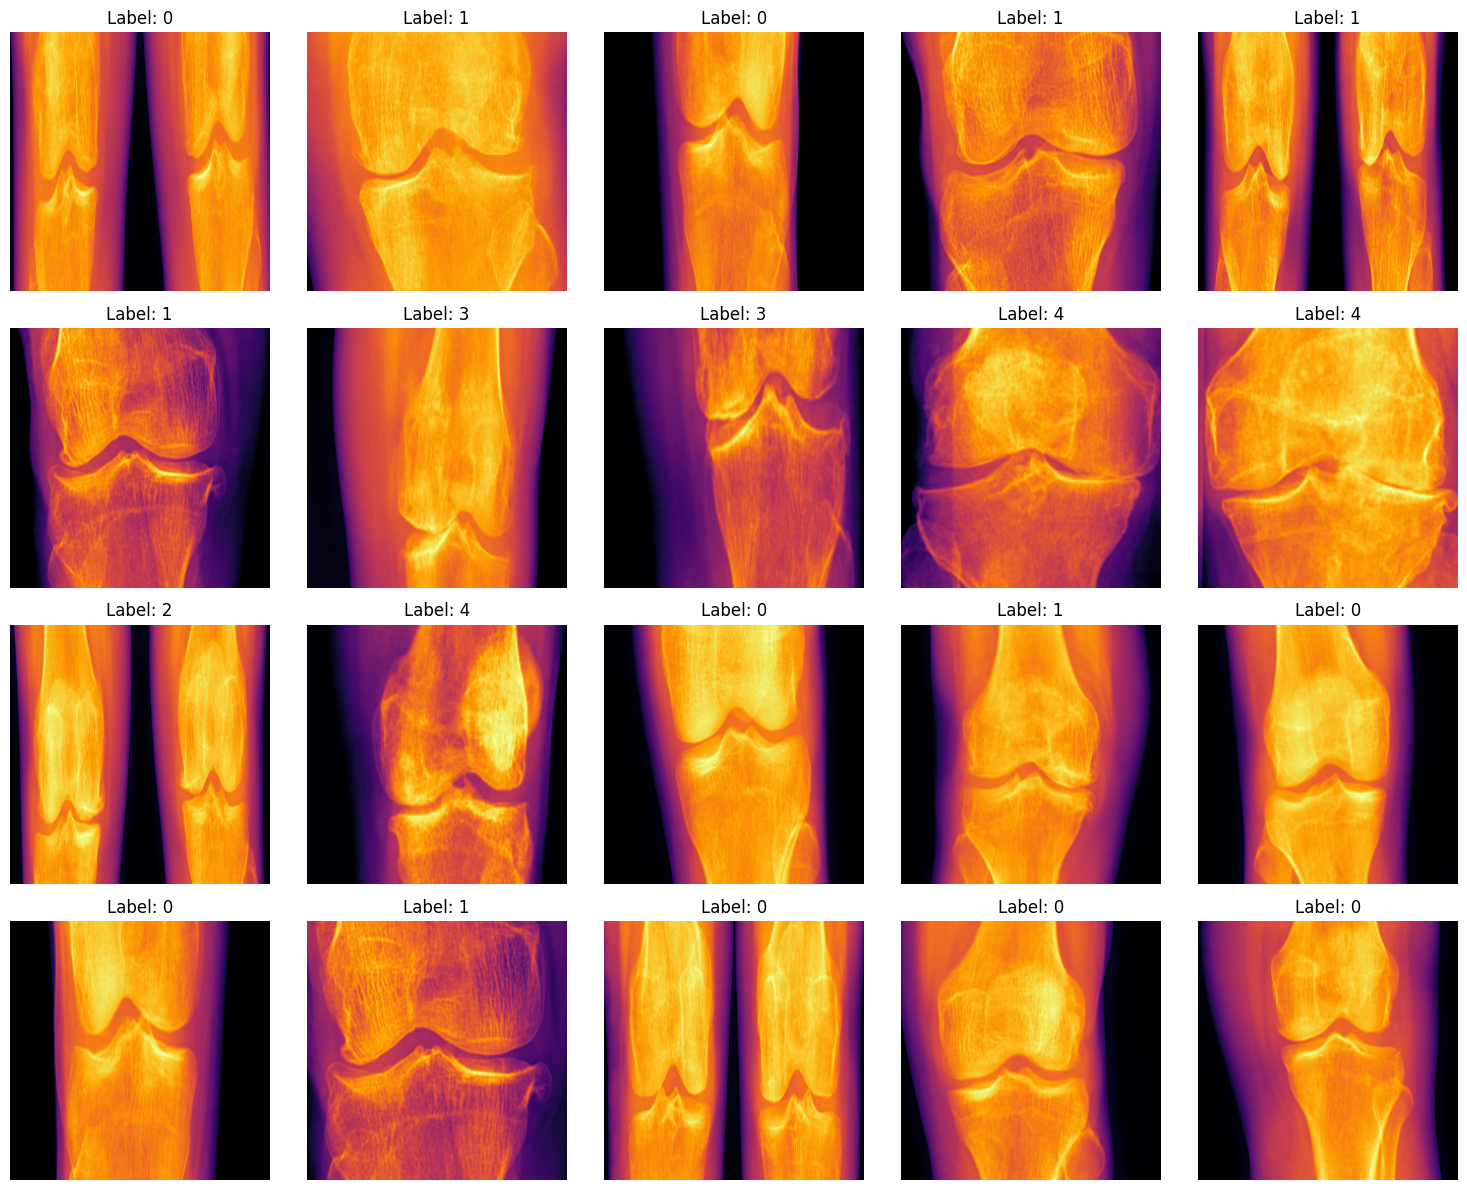

In [ ]:
dataset = image_dataset_from_directory(
    "Training",
    color_mode="grayscale",
    image_size=(256, 256),
    batch_size=None,
)

# Take first 20 images without shuffling
dataset_preview = dataset.take(20)

# Plotting
plt.figure(figsize=(15, 12))

for i, (image, label) in enumerate(dataset_preview):
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8").squeeze(), cmap="inferno")
    plt.title(f"Label: {label.numpy().astype('uint8')}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### 1.3. Split dataset.

In [ ]:
train_dataset, test_dataset = split_dataset(dataset, right_size=0.1)
train_dataset, val_dataset = split_dataset(train_dataset, right_size=0.1)

print("Train size:", train_dataset.cardinality().numpy())
print("Test size:", test_dataset.cardinality().numpy())
print("Validation size:", test_dataset.cardinality().numpy())

Train size: 1337
Test size: 165
Validation size: 165


## 2. Build the initial model architecture.


In [ ]:
inputs = keras.Input(shape=(256, 256, 1))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# Add SE attention block to learn channel importance
x = se_block(x, ratio=16)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 57, 57, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │       737,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,908,965 (7.28 MB)

 Trainable params: 1,908,965 (7.28 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the model.

#### 3.1. Compile and launch training.

In [ ]:
batched_train_dataset = train_dataset.batch(32)
batched_val_dataset = val_dataset.batch(32)

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    batched_train_dataset,
    epochs=20,
    validation_data=batched_val_dataset,
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 633ms/step - accuracy: 0.2562 - loss: 1.6355 - val_accuracy: 0.3514 - val_loss: 1.5242
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - accuracy: 0.2784 - loss: 1.5553 - val_accuracy: 0.3514 - val_loss: 1.5223
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.2792 - loss: 1.5550 - val_accuracy: 0.3514 - val_loss: 1.5208
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.2750 - loss: 1.5534 - val_accuracy: 0.3514 - val_loss: 1.5192
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.2793 - loss: 1.5526 - val_accuracy: 0.3514 - val_loss: 1.5194
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.2685 - loss: 1.5517 - val_accuracy: 0.3514 - val_loss: 1.5196
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.2698 - loss: 1.5508 - val_accuracy: 0.3514 - val_loss: 1.5184
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.2687 - loss: 1.5514 - val_accuracy:

In [ ]:
def show_plots(history):
    accuracy = history["accuracy"]
    val_accuracy = history["val_accuracy"]
    loss = history["loss"]
    val_loss = history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Accuracy on the training step")
    plt.plot(epochs, val_accuracy, "b", label="Accuracy on the validation step")
    plt.title("Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Loss on the training step")
    plt.plot(epochs, val_loss, "b", label="Loss on the validation step")
    plt.title("Loss")
    plt.legend()
    plt.show()

#### 3.2. Show results.

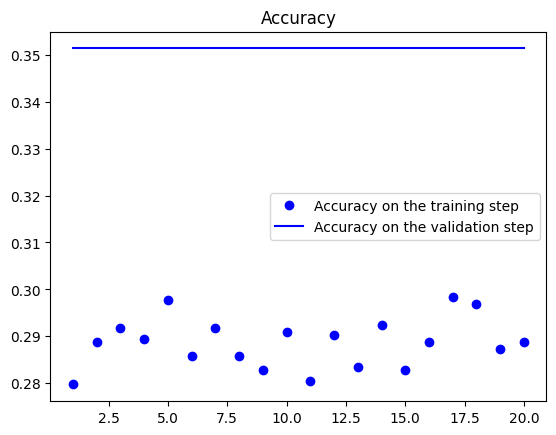

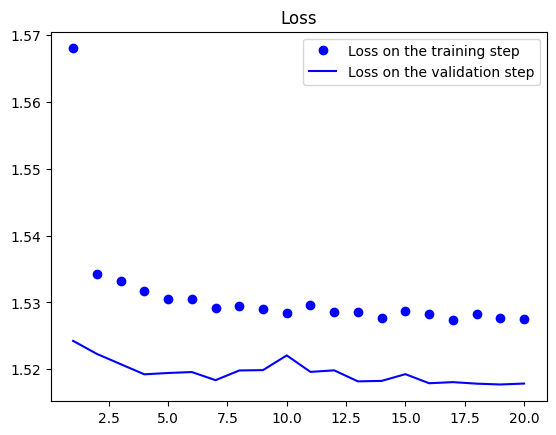

In [ ]:
show_plots(history.history)

## 4. Adjust the model architecture.

#### 4.1. Applying the data augmentation.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

# Add SE attention block to learn channel importance
x = se_block(x, ratio=16

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

batched_train_dataset = train_dataset.batch(32)
batched_val_dataset = val_dataset.batch(32)

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = keras.callbacks.ModelCheckpoint(
    "best_cnn_with_data_augmentation.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)


history = model.fit(
    batched_train_dataset,
    epochs=100,
    validation_data=batched_val_dataset,
    callbacks=callbacks,
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2776 - loss: 1.5847
Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2782 - loss: 1.5838 - val_accuracy: 0.3514 - val_loss: 1.5206
Epoch 2/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2898 - loss: 1.5496
Epoch 2: val_accuracy did not improve from 0.35135
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2920 - loss: 1.5475 - val_accuracy: 0.3108 - val_loss: 1.4918
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2969 - loss: 1.5280
Epoch 3: val_accuracy did not improve from 0.35135
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2973 - loss: 1.5275 - val_accuracy: 0.3108 - val_loss: 1.4734
Epoch 4/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3091 - loss: 1.5183
Epoch 4: val_accuracy improved from 0.35135 to 0.36486, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3105 - loss: 1.5168 - val_accuracy: 0.3649 - val_loss: 1.4644
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3222 - loss: 1.5122
Epoch 5: val_accuracy did not improve from 0.36486
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3224 - loss: 1.5116 - val_accuracy: 0.3649 - val_loss: 1.4429
Epoch 6/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3192 - loss: 1.5095
Epoch 6: val_accuracy improved from 0.36486 to 0.37162, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3207 - loss: 1.5075 - val_accuracy: 0.3716 - val_loss: 1.4426
Epoch 7/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3329 - loss: 1.4994
Epoch 7: val_accuracy did not improve from 0.37162
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3333 - loss: 1.4983 - val_accuracy: 0.3716 - val_loss: 1.4391
Epoch 8/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3530 - loss: 1.4895
Epoch 8: val_accuracy improved from 0.37162 to 0.38514, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3534 - loss: 1.4877 - val_accuracy: 0.3851 - val_loss: 1.4244
Epoch 9/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3505 - loss: 1.4826
Epoch 9: val_accuracy did not improve from 0.38514
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3509 - loss: 1.4810 - val_accuracy: 0.3784 - val_loss: 1.4143
Epoch 10/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3545 - loss: 1.4506
Epoch 10: val_accuracy did not improve from 0.38514
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3545 - loss: 1.4498 - val_accuracy: 0.3784 - val_loss: 1.3934
Epoch 11/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3568 - loss: 1.4620
Epoch 11: val_accuracy did not improve from 0.38514
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3572 - loss: 1.4608 - val_accuracy: 0.3581 - val_loss: 1.4203
Epoch 12/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3765 - loss: 1.4362
Epoch 12: val_accuracy did not imp

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3962 - loss: 1.4002 - val_accuracy: 0.4257 - val_loss: 1.4124
Epoch 15/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3852 - loss: 1.3896
Epoch 15: val_accuracy did not improve from 0.42568
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3860 - loss: 1.3885 - val_accuracy: 0.4189 - val_loss: 1.3582
Epoch 16/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4042 - loss: 1.3622
Epoch 16: val_accuracy did not improve from 0.42568
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4048 - loss: 1.3611 - val_accuracy: 0.4189 - val_loss: 1.3230
Epoch 17/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4147 - loss: 1.3602
Epoch 17: val_accuracy improved from 0.42568 to 0.46622, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4152 - loss: 1.3590 - val_accuracy: 0.4662 - val_loss: 1.2729
Epoch 18/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4320 - loss: 1.3336
Epoch 18: val_accuracy did not improve from 0.46622
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4323 - loss: 1.3320 - val_accuracy: 0.4189 - val_loss: 1.3336
Epoch 19/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4125 - loss: 1.3439
Epoch 19: val_accuracy did not improve from 0.46622
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4140 - loss: 1.3407 - val_accuracy: 0.4527 - val_loss: 1.2443
Epoch 20/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4217 - loss: 1.3003
Epoch 20: val_accuracy improved from 0.46622 to 0.50000, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4235 - loss: 1.2991 - val_accuracy: 0.5000 - val_loss: 1.1831
Epoch 21/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4364 - loss: 1.3176
Epoch 21: val_accuracy did not improve from 0.50000
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4377 - loss: 1.3161 - val_accuracy: 0.4595 - val_loss: 1.2167
Epoch 22/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4765 - loss: 1.2720
Epoch 22: val_accuracy did not improve from 0.50000
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4766 - loss: 1.2710 - val_accuracy: 0.4662 - val_loss: 1.1844
Epoch 23/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4276 - loss: 1.2776
Epoch 23: val_accuracy improved from 0.50000 to 0.52027, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4290 - loss: 1.2759 - val_accuracy: 0.5203 - val_loss: 1.1349
Epoch 24/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4567 - loss: 1.2771
Epoch 24: val_accuracy did not improve from 0.52027
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4580 - loss: 1.2751 - val_accuracy: 0.5068 - val_loss: 1.1306
Epoch 25/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4639 - loss: 1.2620
Epoch 25: val_accuracy did not improve from 0.52027
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4651 - loss: 1.2612 - val_accuracy: 0.5068 - val_loss: 1.1207
Epoch 26/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4703 - loss: 1.2424
Epoch 26: val_accuracy did not improve from 0.52027
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4707 - loss: 1.2419 - val_accuracy: 0.5000 - val_loss: 1.1785
Epoch 27/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4852 - loss: 1.2262
Epoch 27: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4877 - loss: 1.1924 - val_accuracy: 0.5608 - val_loss: 1.0875
Epoch 32/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4969 - loss: 1.1723
Epoch 32: val_accuracy did not improve from 0.56081
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4983 - loss: 1.1712 - val_accuracy: 0.5068 - val_loss: 1.0875
Epoch 33/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5136 - loss: 1.1539
Epoch 33: val_accuracy did not improve from 0.56081
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5147 - loss: 1.1532 - val_accuracy: 0.5473 - val_loss: 1.0921
Epoch 34/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5166 - loss: 1.1414
Epoch 34: val_accuracy did not improve from 0.56081
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5186 - loss: 1.1401 - val_accuracy: 0.5473 - val_loss: 1.0887
Epoch 35/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5513 - loss: 1.1273
Epoch 35: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5799 - loss: 1.0328 - val_accuracy: 0.5878 - val_loss: 1.0522
Epoch 45/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5704 - loss: 1.0369
Epoch 45: val_accuracy did not improve from 0.58784
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5709 - loss: 1.0372 - val_accuracy: 0.5743 - val_loss: 1.0329
Epoch 46/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5703 - loss: 1.0209
Epoch 46: val_accuracy did not improve from 0.58784
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5712 - loss: 1.0200 - val_accuracy: 0.5811 - val_loss: 1.0274
Epoch 47/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5655 - loss: 1.0519
Epoch 47: val_accuracy did not improve from 0.58784
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5668 - loss: 1.0487 - val_accuracy: 0.5743 - val_loss: 1.0089
Epoch 48/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5700 - loss: 1.0211
Epoch 48: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5976 - loss: 0.9835 - val_accuracy: 0.5946 - val_loss: 0.9842
Epoch 52/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6133 - loss: 0.9796
Epoch 52: val_accuracy did not improve from 0.59459
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6130 - loss: 0.9797 - val_accuracy: 0.5473 - val_loss: 1.0316
Epoch 53/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5815 - loss: 0.9881
Epoch 53: val_accuracy did not improve from 0.59459
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5822 - loss: 0.9877 - val_accuracy: 0.5878 - val_loss: 1.0008
Epoch 54/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6013 - loss: 0.9871
Epoch 54: val_accuracy did not improve from 0.59459
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6022 - loss: 0.9860 - val_accuracy: 0.5811 - val_loss: 1.0375
Epoch 55/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6261 - loss: 0.9309
Epoch 55: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6137 - loss: 0.9540 - val_accuracy: 0.6081 - val_loss: 0.9857
Epoch 62/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6097 - loss: 0.9653
Epoch 62: val_accuracy did not improve from 0.60811
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6110 - loss: 0.9617 - val_accuracy: 0.5811 - val_loss: 1.0836
Epoch 63/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6275 - loss: 0.9302
Epoch 63: val_accuracy did not improve from 0.60811
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6283 - loss: 0.9285 - val_accuracy: 0.5743 - val_loss: 0.9956
Epoch 64/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6215 - loss: 0.9154
Epoch 64: val_accuracy did not improve from 0.60811
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6220 - loss: 0.9147 - val_accuracy: 0.5811 - val_loss: 1.0091
Epoch 65/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6269 - loss: 0.8870
Epoch 65: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6175 - loss: 0.9066 - val_accuracy: 0.6149 - val_loss: 0.9885
Epoch 67/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6266 - loss: 0.8863
Epoch 67: val_accuracy did not improve from 0.61486
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6279 - loss: 0.8842 - val_accuracy: 0.5811 - val_loss: 1.1193
Epoch 68/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6376 - loss: 0.8995
Epoch 68: val_accuracy did not improve from 0.61486
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6386 - loss: 0.8983 - val_accuracy: 0.5811 - val_loss: 1.0143
Epoch 69/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6275 - loss: 0.9203
Epoch 69: val_accuracy did not improve from 0.61486
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6280 - loss: 0.9195 - val_accuracy: 0.6081 - val_loss: 1.0192
Epoch 70/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6684 - loss: 0.8647
Epoch 70: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6678 - loss: 0.8485 - val_accuracy: 0.6216 - val_loss: 1.0250
Epoch 73/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6480 - loss: 0.8768
Epoch 73: val_accuracy did not improve from 0.62162
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6482 - loss: 0.8761 - val_accuracy: 0.5878 - val_loss: 1.0376
Epoch 74/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6397 - loss: 0.9020
Epoch 74: val_accuracy did not improve from 0.62162
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6403 - loss: 0.9004 - val_accuracy: 0.5946 - val_loss: 1.0254
Epoch 75/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6453 - loss: 0.8708
Epoch 75: val_accuracy did not improve from 0.62162
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6458 - loss: 0.8695 - val_accuracy: 0.6014 - val_loss: 1.0092
Epoch 76/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6153 - loss: 0.8485
Epoch 76: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6622 - loss: 0.8641 - val_accuracy: 0.6351 - val_loss: 1.0116
Epoch 78/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6740 - loss: 0.8416
Epoch 78: val_accuracy did not improve from 0.63514
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6741 - loss: 0.8405 - val_accuracy: 0.6284 - val_loss: 1.0091
Epoch 79/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6646 - loss: 0.8474
Epoch 79: val_accuracy did not improve from 0.63514
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6651 - loss: 0.8461 - val_accuracy: 0.5946 - val_loss: 1.1060
Epoch 80/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6627 - loss: 0.8469
Epoch 80: val_accuracy did not improve from 0.63514
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6630 - loss: 0.8461 - val_accuracy: 0.6149 - val_loss: 0.9826
Epoch 81/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6771 - loss: 0.7968
Epoch 81: val_accuracy did not i

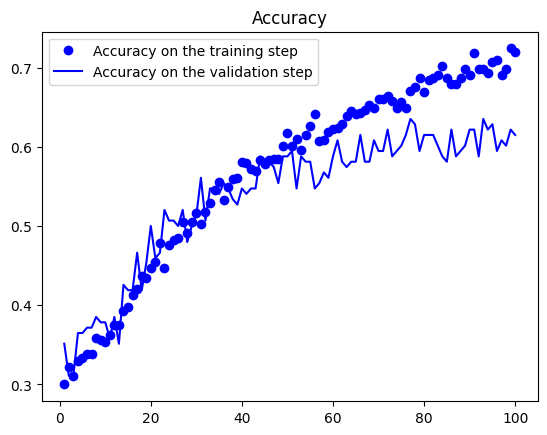

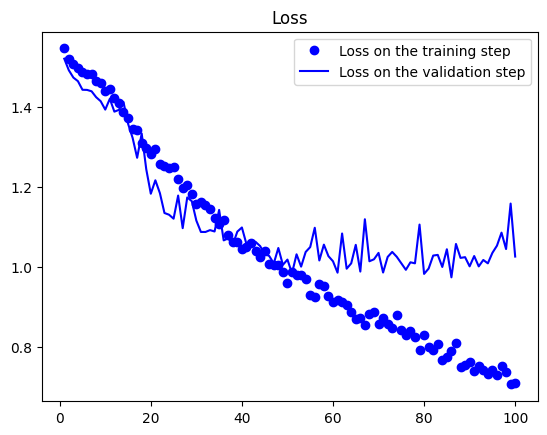

In [ ]:
show_plots(history.history)

In [ ]:
max(history.history["val_accuracy"])

# To improve the model, we cropped the knee region to focus only on the joint, enhanced the X-ray contrast for clearer visibility, and applied various data augmentations — which helped the model understand the features better.

0.6351351141929626

In [ ]:
loaded_model = keras.models.load_model("best_cnn_with_data_augmentation.h5")
loaded_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 254, 254, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │        92,165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,407 (743.78 KB)

 Trainable params: 190,405 (743.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
loaded_model.evaluate(test_dataset.batch(32))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6437 - loss: 0.9403


[0.9451746940612793, 0.6181818246841431]

#### 4.2. Add fully-connected layers.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Add SE attention block to learn channel importance
x = se_block(x, ratio=16)

x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

batched_train_dataset = train_dataset.batch(16)
batched_val_dataset = val_dataset.batch(16)

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = keras.callbacks.ModelCheckpoint(
    "best_cnn_with_data_augmentation_and_dense.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

history = model.fit(
    batched_train_dataset,
    epochs=300,
    validation_data=batched_val_dataset,
    callbacks=callbacks,
)

Epoch 1/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2749 - loss: 1.5858
Epoch 1: val_accuracy improved from -inf to 0.33784, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2752 - loss: 1.5854 - val_accuracy: 0.3378 - val_loss: 1.5244
Epoch 2/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2927 - loss: 1.5486
Epoch 2: val_accuracy did not improve from 0.33784
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2935 - loss: 1.5472 - val_accuracy: 0.3378 - val_loss: 1.4907
Epoch 3/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3192 - loss: 1.5235
Epoch 3: val_accuracy did not improve from 0.33784
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3193 - loss: 1.5225 - val_accuracy: 0.3378 - val_loss: 1.4715
Epoch 4/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3245 - loss: 1.5096
Epoch 4: val_accuracy improved from 0.33784 to 0.35135, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3245 - loss: 1.5084 - val_accuracy: 0.3514 - val_loss: 1.4704
Epoch 5/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3352 - loss: 1.5122
Epoch 5: val_accuracy did not improve from 0.35135
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3354 - loss: 1.5111 - val_accuracy: 0.3311 - val_loss: 1.4569
Epoch 6/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3350 - loss: 1.5053
Epoch 6: val_accuracy did not improve from 0.35135
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3353 - loss: 1.5041 - val_accuracy: 0.3514 - val_loss: 1.4247
Epoch 7/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3501 - loss: 1.4906
Epoch 7: val_accuracy improved from 0.35135 to 0.36486, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3500 - loss: 1.4894 - val_accuracy: 0.3649 - val_loss: 1.4107
Epoch 8/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3516 - loss: 1.4725
Epoch 8: val_accuracy improved from 0.36486 to 0.37838, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3516 - loss: 1.4722 - val_accuracy: 0.3784 - val_loss: 1.4100
Epoch 9/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3677 - loss: 1.4504
Epoch 9: val_accuracy improved from 0.37838 to 0.42568, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3676 - loss: 1.4494 - val_accuracy: 0.4257 - val_loss: 1.3959
Epoch 10/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4014 - loss: 1.4207
Epoch 10: val_accuracy improved from 0.42568 to 0.47297, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4009 - loss: 1.4201 - val_accuracy: 0.4730 - val_loss: 1.3335
Epoch 11/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3909 - loss: 1.3939
Epoch 11: val_accuracy did not improve from 0.47297
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3908 - loss: 1.3929 - val_accuracy: 0.4054 - val_loss: 1.3205
Epoch 12/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4287 - loss: 1.3580
Epoch 12: val_accuracy did not improve from 0.47297
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4285 - loss: 1.3579 - val_accuracy: 0.2973 - val_loss: 1.5327
Epoch 13/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3987 - loss: 1.3584
Epoch 13: val_accuracy did not improve from 0.47297
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3994 - loss: 1.3572 - val_accuracy: 0.3649 - val_loss: 1.3208
Epoch 14/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4383 - loss: 1.3114
Epoch 14: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4618 - loss: 1.3016 - val_accuracy: 0.4797 - val_loss: 1.2267
Epoch 16/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4466 - loss: 1.2741
Epoch 16: val_accuracy did not improve from 0.47973
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4474 - loss: 1.2725 - val_accuracy: 0.4662 - val_loss: 1.3048
Epoch 17/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4753 - loss: 1.2458
Epoch 17: val_accuracy improved from 0.47973 to 0.52703, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4757 - loss: 1.2445 - val_accuracy: 0.5270 - val_loss: 1.1356
Epoch 18/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4678 - loss: 1.2122
Epoch 18: val_accuracy did not improve from 0.52703
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4679 - loss: 1.2119 - val_accuracy: 0.3851 - val_loss: 1.3527
Epoch 19/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4607 - loss: 1.2405
Epoch 19: val_accuracy did not improve from 0.52703
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4620 - loss: 1.2383 - val_accuracy: 0.5000 - val_loss: 1.1816
Epoch 20/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5051 - loss: 1.1776
Epoch 20: val_accuracy did not improve from 0.52703
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5050 - loss: 1.1775 - val_accuracy: 0.4797 - val_loss: 1.1766
Epoch 21/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4967 - loss: 1.1854
Epoch 21: val_accuracy improved 

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4968 - loss: 1.1848 - val_accuracy: 0.5811 - val_loss: 1.0752
Epoch 22/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5070 - loss: 1.1659
Epoch 22: val_accuracy did not improve from 0.58108
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5073 - loss: 1.1654 - val_accuracy: 0.5811 - val_loss: 1.0305
Epoch 23/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5291 - loss: 1.1150
Epoch 23: val_accuracy did not improve from 0.58108
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5295 - loss: 1.1144 - val_accuracy: 0.4797 - val_loss: 1.2295
Epoch 24/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5239 - loss: 1.1042
Epoch 24: val_accuracy improved from 0.58108 to 0.61486, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5250 - loss: 1.1025 - val_accuracy: 0.6149 - val_loss: 1.0103
Epoch 25/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5164 - loss: 1.1169
Epoch 25: val_accuracy did not improve from 0.61486
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5173 - loss: 1.1153 - val_accuracy: 0.5473 - val_loss: 1.0813
Epoch 26/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5223 - loss: 1.0976
Epoch 26: val_accuracy did not improve from 0.61486
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5236 - loss: 1.0964 - val_accuracy: 0.4797 - val_loss: 1.2144
Epoch 27/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5408 - loss: 1.0469
Epoch 27: val_accuracy did not improve from 0.61486
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5423 - loss: 1.0454 - val_accuracy: 0.5405 - val_loss: 1.0660
Epoch 28/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5409 - loss: 1.0745
Epoch 28: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6360 - loss: 0.8996 - val_accuracy: 0.6351 - val_loss: 1.0476
Epoch 44/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6455 - loss: 0.8701
Epoch 44: val_accuracy did not improve from 0.63514
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6459 - loss: 0.8698 - val_accuracy: 0.5473 - val_loss: 1.0891
Epoch 45/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6369 - loss: 0.8686
Epoch 45: val_accuracy did not improve from 0.63514
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6371 - loss: 0.8683 - val_accuracy: 0.6014 - val_loss: 1.1583
Epoch 46/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6262 - loss: 0.9214
Epoch 46: val_accuracy did not improve from 0.63514
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6271 - loss: 0.9192 - val_accuracy: 0.5811 - val_loss: 1.2018
Epoch 47/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6478 - loss: 0.8897
Epoch 47: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6906 - loss: 0.8386 - val_accuracy: 0.6757 - val_loss: 0.9728
Epoch 56/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6580 - loss: 0.8488
Epoch 56: val_accuracy did not improve from 0.67568
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6594 - loss: 0.8456 - val_accuracy: 0.6351 - val_loss: 1.1524
Epoch 57/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6773 - loss: 0.8278
Epoch 57: val_accuracy did not improve from 0.67568
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6783 - loss: 0.8251 - val_accuracy: 0.6419 - val_loss: 1.0567
Epoch 58/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7129 - loss: 0.7676
Epoch 58: val_accuracy improved from 0.67568 to 0.68919, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7127 - loss: 0.7675 - val_accuracy: 0.6892 - val_loss: 0.9633
Epoch 59/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6784 - loss: 0.8176
Epoch 59: val_accuracy did not improve from 0.68919
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6788 - loss: 0.8163 - val_accuracy: 0.6351 - val_loss: 1.0671
Epoch 60/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6972 - loss: 0.8092
Epoch 60: val_accuracy did not improve from 0.68919
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6979 - loss: 0.8071 - val_accuracy: 0.5946 - val_loss: 1.3330
Epoch 61/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6677 - loss: 0.8169
Epoch 61: val_accuracy did not improve from 0.68919
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6693 - loss: 0.8139 - val_accuracy: 0.6419 - val_loss: 1.0237
Epoch 62/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7013 - loss: 0.7693
Epoch 62: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7261 - loss: 0.7267 - val_accuracy: 0.6959 - val_loss: 0.9293
Epoch 70/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7334 - loss: 0.7084
Epoch 70: val_accuracy did not improve from 0.69595
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7336 - loss: 0.7077 - val_accuracy: 0.6216 - val_loss: 1.2195
Epoch 71/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7306 - loss: 0.6790
Epoch 71: val_accuracy did not improve from 0.69595
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7306 - loss: 0.6792 - val_accuracy: 0.6216 - val_loss: 1.1966
Epoch 72/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7078 - loss: 0.7100
Epoch 72: val_accuracy did not improve from 0.69595
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7082 - loss: 0.7102 - val_accuracy: 0.6554 - val_loss: 0.9666
Epoch 73/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7354 - loss: 0.6750
Epoch 73: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7760 - loss: 0.6029 - val_accuracy: 0.7095 - val_loss: 0.9746
Epoch 104/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7746 - loss: 0.5664
Epoch 104: val_accuracy did not improve from 0.70946
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7747 - loss: 0.5666 - val_accuracy: 0.6824 - val_loss: 1.0995
Epoch 105/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7890 - loss: 0.5893
Epoch 105: val_accuracy did not improve from 0.70946
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7888 - loss: 0.5896 - val_accuracy: 0.6689 - val_loss: 1.0880
Epoch 106/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7898 - loss: 0.5640
Epoch 106: val_accuracy did not improve from 0.70946
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7891 - loss: 0.5645 - val_accuracy: 0.6554 - val_loss: 1.0467
Epoch 107/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7986 - loss: 0.5538
Epoch 107: val_accuracy d

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8259 - loss: 0.4738 - val_accuracy: 0.7297 - val_loss: 1.1860
Epoch 145/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8081 - loss: 0.5310
Epoch 145: val_accuracy did not improve from 0.72973
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8081 - loss: 0.5312 - val_accuracy: 0.6689 - val_loss: 1.1663
Epoch 146/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8394 - loss: 0.5202
Epoch 146: val_accuracy did not improve from 0.72973
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8392 - loss: 0.5185 - val_accuracy: 0.6216 - val_loss: 1.1484
Epoch 147/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8026 - loss: 0.5532
Epoch 147: val_accuracy did not improve from 0.72973
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8026 - loss: 0.5521 - val_accuracy: 0.6824 - val_loss: 1.1867
Epoch 148/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8209 - loss: 0.4906
Epoch 148: val_accuracy d

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8054 - loss: 0.5262 - val_accuracy: 0.7432 - val_loss: 1.4843
Epoch 191/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8441 - loss: 0.4503
Epoch 191: val_accuracy did not improve from 0.74324
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8441 - loss: 0.4504 - val_accuracy: 0.6554 - val_loss: 1.0416
Epoch 192/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8135 - loss: 0.4679
Epoch 192: val_accuracy did not improve from 0.74324
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8142 - loss: 0.4671 - val_accuracy: 0.6689 - val_loss: 1.0778
Epoch 193/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8445 - loss: 0.4587
Epoch 193: val_accuracy did not improve from 0.74324
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8442 - loss: 0.4592 - val_accuracy: 0.6419 - val_loss: 1.3220
Epoch 194/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8545 - loss: 0.4331
Epoch 194: val_accuracy d

In [ ]:
max(history.history["val_accuracy"])

0.7770270109176636

In [ ]:
loaded_model = keras.models.load_model("best_cnn_with_data_augmentation_and_dense.h5")
loaded_model.evaluate(test_dataset.batch(32))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6732 - loss: 0.8483 


[0.8059360384941101, 0.6969696879386902]

In [ ]:
loaded_model.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 254, 254, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,345,223 (20.39 MB)

 Trainable params: 5,345,221 (20.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

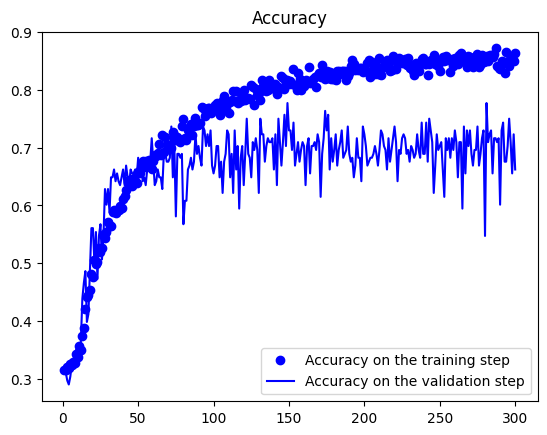

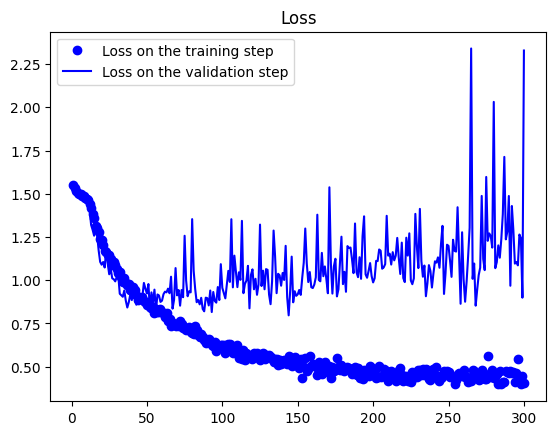

In [ ]:
show_plots(history.history)

In [ ]:
# Evaluate on test dataset
test_loss, test_acc = loaded_model.evaluate(test_dataset.batch(32), verbose=0)

# Extract training and validation accuracy history
train_acc_final = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])

# Print final results
print(f"✅ Final Training Accuracy    : {train_acc_final * 100:.2f}%")
print(f"✅ Best Validation Accuracy   : {best_val_acc * 100:.2f}%")
print(f"✅ Final Test Accuracy        : {test_acc * 100:.2f}%")

✅ Final Training Accuracy    : 86.39%
✅ Best Validation Accuracy   : 77.70%
✅ Final Test Accuracy        : 69.70%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Actual Label: 4 | Predicted Label: 4


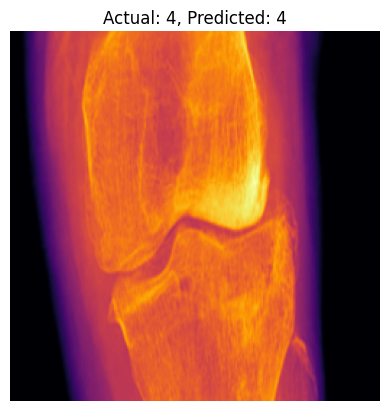


✅ Matched: 1/1
📊 Accuracy: 100.00%


In [ ]:
correct_predictions = 0
total_predictions = 1

# Shuffle and take 5 random samples
for image, label in test_dataset.shuffle(1000).take(total_predictions):
    # Expand dimensions to make it a batch of one image
    img = np.expand_dims(image.numpy(), axis=0)

    # Predict using the loaded model
    prediction = loaded_model.predict(img)
    predicted_label = np.argmax(prediction)

    # Actual label
    actual_label = label.numpy().astype("uint8")

    # Check if prediction is correct
    if predicted_label == actual_label:
        correct_predictions += 1

    # Print and show image
    print(f"Actual Label: {actual_label} | Predicted Label: {predicted_label}")
    plt.imshow(image.numpy().astype("uint8").squeeze(), cmap="inferno")
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# 🔢 Accuracy
accuracy = (correct_predictions / total_predictions) * 100
print(f"\n✅ Matched: {correct_predictions}/{total_predictions}")
print(f"📊 Accuracy: {accuracy:.2f}%")